# Aspect-Based Sentiment Analysis
Dataset: [Restaurant Reviews](https://github.com/siat-nlp/MAMS-for-ABSA)

In [ ]:
!pip install transformers -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import TFBertModel, BertTokenizerFast

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(42)

## Load Dataset

In [ ]:
train = pd.read_csv('train.csv')
train.fillna('None', inplace=True)
train.head()

,Text,food,place,staff,miscellaneous,service,price,menu,ambience
0,It might be the best sit down food I've had in...,positive,neutral,None,None,None,None,None,None
1,Hostess was extremely accommodating when we ar...,None,None,positive,neutral,None,None,None,None
2,We were a couple of minutes late for our reser...,None,None,negative,neutral,None,None,None,None
3,"Though the service might be a little slow, the...",None,None,positive,None,negative,None,None,None
4,Although we arrived at the restaurant 10 min l...,None,None,negative,neutral,None,None,None,None


In [ ]:
val = pd.read_csv('val.csv')
val.fillna('None', inplace=True)
val.head()

,Text,miscellaneous,food,staff,service,menu,place,price,ambience
0,"I would wait for a table next time, the food w...",neutral,positive,None,None,None,None,None,None
1,"We did complain to the manager, but she just s...",None,neutral,negative,None,None,None,None,None
2,the service was inattentive (didn't bring us w...,None,neutral,None,negative,None,None,None,None
3,"decent, if greasy, fishsticks, but served on a...",None,negative,None,neutral,None,None,None,None
4,"The Filet Mignon is awesome, along with everyt...",None,positive,None,None,neutral,None,None,None


In [ ]:
test = pd.read_csv('test.csv')
test.fillna('None', inplace=True)
test.head()

,Text,place,food,service,staff,miscellaneous,price,menu,ambience
0,"We went again and sat at the bar this time, I ...",neutral,negative,None,None,None,None,None,None
1,"The food was good, but it's not worth the wait...",None,positive,negative,None,None,None,None,None
2,Waiter took our drink order and then we didn't...,None,None,None,negative,neutral,None,None,None
3,It does get crowded with plenty of blue shirte...,None,negative,None,None,neutral,None,None,None
4,"After hearing all of the specials, you would t...",None,neutral,None,None,None,negative,None,None


## Download BERT Model

In [ ]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizerFast.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Data Preprocessing

In [ ]:
def tokenize(text, max_length=128):
    return tokenizer(text=text,
                     add_special_tokens=True,
                     max_length=max_length,
                     truncation=True,
                     padding='max_length',
                     return_tensors='tf',
                     return_token_type_ids=False,
                     return_attention_mask=True,
                     verbose=True)

def encode(df, columns, categories=None):
    ys = {}
    for column in columns:
        df[column] = pd.Categorical(df[column], categories=categories).codes
        ys[column] = to_categorical(df[column], num_classes=len(categories))
    return ys

aspects = ['food', 'place', 'staff', 'service', 'price', 'menu', 'ambience', 'miscellaneous']
sentiments = ['None', 'positive', 'negative', 'neutral']

In [ ]:
X_train = tokenize(train['Text'].to_list())
y_train = encode(train, aspects, categories=sentiments)

X_train.input_ids.shape

TensorShape([3149, 128])

In [ ]:
X_val = tokenize(val['Text'].to_list())
y_val = encode(val, aspects, categories=sentiments)

X_val.input_ids.shape

TensorShape([400, 128])

In [ ]:
X_test = tokenize(test['Text'].to_list())
y_test = encode(test, aspects, categories=sentiments)

X_test.input_ids.shape

TensorShape([400, 128])

## Model Architecture

Input Layer

In [ ]:
input_ids = Input(shape=(128,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(128,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

BERT Layer

In [ ]:
bert_outputs = bert_model(inputs)

dense = Dense(units=256, activation='relu', name='dense')(bert_outputs.pooler_output)
dropout = Dropout(0.3, name='dropout')(dense)

Output Layer

In [ ]:
food = Dense(units=4, name='food')(dropout)
place = Dense(units=4, name='place')(dropout)
staff = Dense(units=4, name='staff')(dropout)
service = Dense(units=4, name='service')(dropout)
price = Dense(units=4, name='price')(dropout)
menu = Dense(units=4, name='menu')(dropout)
ambience = Dense(units=4, name='ambience')(dropout)
miscellaneous = Dense(units=4, name='miscellaneous')(dropout)

outputs = {'food': food,
           'place': place,
           'staff': staff,
           'service': service,
           'price': price,
           'menu': menu,
           'ambience': ambience,
           'miscellaneous': miscellaneous}

In [ ]:
model = Model(inputs=inputs, outputs=outputs, name='BERT_Model')
model.summary()

Model: "BERT_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['attention_mask[0][0]',      
 )                           ngAndCrossAttentions(last_   40         'input_ids[0][0]']           
                             hidden_state=(None, 128, 7                                  

## Model Training

In [ ]:
optimizer = Adam(learning_rate=1e-04, epsilon=1e-08)
loss = CategoricalCrossentropy(from_logits=True)
metric = F1Score(average='weighted')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
X_train = {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']}
X_val = {'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']}

history = model.fit(x=X_train, y=y_train,
                    batch_size=32, epochs=4, verbose=0, validation_data=(X_val, y_val))

## Evaluation

In [ ]:
X_test = {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}

eval = model.evaluate(x=X_test, y=y_test, verbose=0, return_dict=True)

In [ ]:
def plot_metrics(history, eval, aspects, metric='f1_score'):
    fig, axs = plt.subplots(4, 2, figsize=(12, 18))
    plt.subplots_adjust(hspace=0.3)

    for i, ax in enumerate(axs.flatten()):
        x = history.epoch

        y_train = history.history[aspects[i] + '_' + metric]
        ax.plot(x, y_train, marker='.', label=f'Train: {y_train[-1]:.2f}')

        y_val = history.history['val_' + aspects[i] + '_' + metric]
        ax.plot(x, y_val, marker='.', label=f'Validation: {y_val[-1]:.2f}')

        y_test = eval[aspects[i] + '_' + metric]
        ax.plot(x[-1], y_test, marker='.', label=f'Test: {y_test:.2f}')

        ax.set_ylim(0, None) if metric == 'loss' else ax.set_ylim(0, 1)
        ax.set_title(aspects[i].capitalize())
        ax.set_xticks(x)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend();

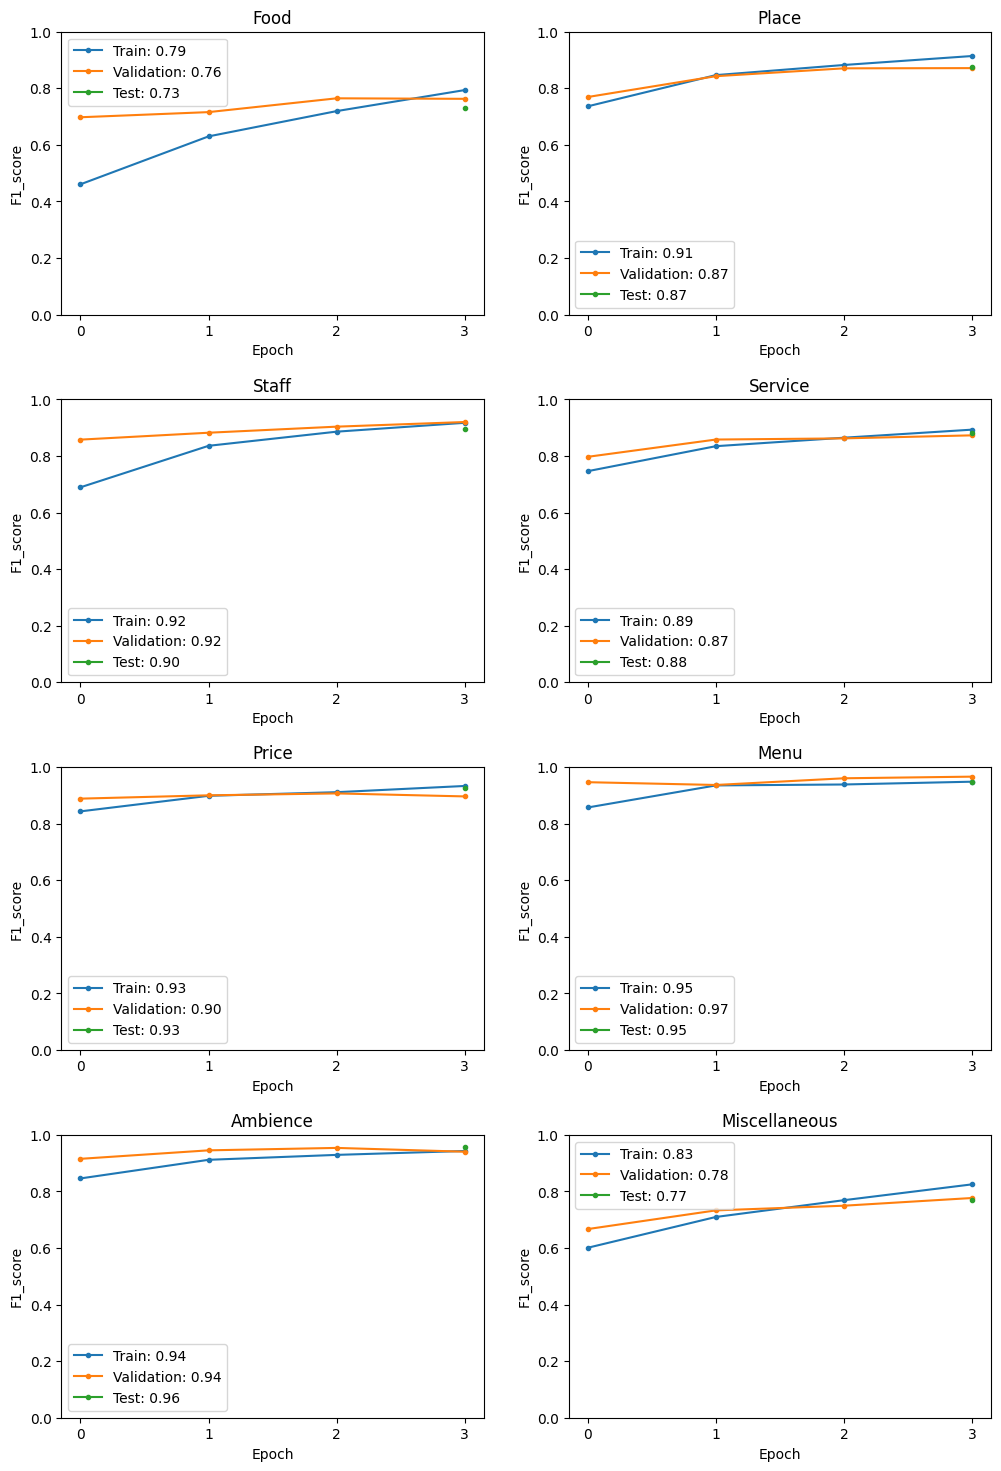

In [ ]:
plot_metrics(history, eval, aspects)

## Prediction

In [ ]:
X_pred = tokenize('The food was delicious, but it took a long time to be served.')
X_pred = {'input_ids': X_pred['input_ids'], 'attention_mask': X_pred['attention_mask']}

pred = model.predict(X_pred)
for aspect in pred.keys():
    sentiment = np.argmax(pred[aspect], axis=1)[0]

    if sentiment != 0:
        print(aspect, ': ', 'positive' if sentiment == 1 else ('negative' if sentiment == 2 else 'neutral'))

1/1 [==============================] - 3s 3s/step
food :  positive
service :  negative
